<a href="https://colab.research.google.com/github/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/project-face-generation/dlnd_face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='https://github.com/priyeshkap/deep-learning-v2-pytorch/blob/pk_solutions/project-face-generation/assets/processed_face_data.png?raw=1' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget --no-check-certificate --no-proxy 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'

--2020-05-31 13:38:55--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.241.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.241.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  16.5MB/s    in 16s     

2020-05-31 13:39:12 (14.8 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [3]:
# can comment out after executing
!unzip -n processed-celeba-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052344.jpg  
  inflating: 

In [4]:
%cd '/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/project-face-generation/'

#import problem_unittests.py
import imp 
problem_unittests = imp.new_module('problem_unittests')
exec(open("./problem_unittests.py").read(), problem_unittests.__dict__)

/content/drive/My Drive/Udacity/deep-learning-v2-pytorch/project-face-generation


In [0]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [6]:
%cd '/content/'

/content


## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [0]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    # resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # define dataset using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoader
    data_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [0]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

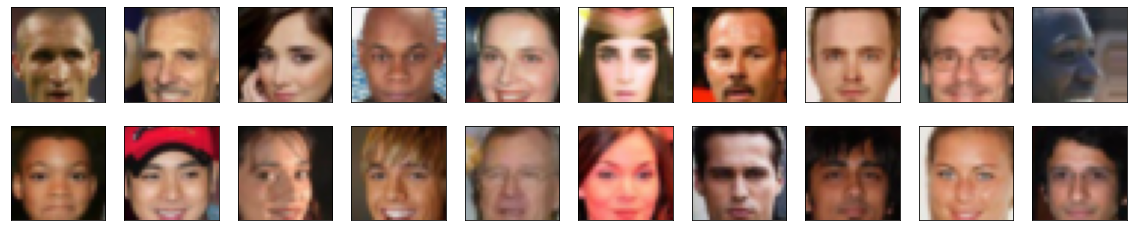

In [10]:
# helper display function
def imshow(img):
    # convert pytorch tensor to numpy
    npimg = img.numpy()
    # change dimensions of image [3 x 32 x 32] => [32 x 32 x 3]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [0]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    f_min, f_max = feature_range
    x = x * (f_max - f_min) + f_min
    return x

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.7176)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch Conv2d convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with Conv2d and optional BatchNorm2d layers
    """
    conv_layer = nn.Conv2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [26]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        # 32x32x3 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # No batch norm in first layer
        # 16x16x32
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4x128
        self.fc = nn.Linear(4 * 4 * conv_dim*4, 1)  # (2048, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4 * 4 * self.conv_dim*4)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [0]:
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch ConvTranspose2d transpose convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with ConvTranspose2d and optional BatchNorm2d layers
    """
    t_conv_layer = nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [t_conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [28]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.z_size = z_size

        self.fc1 = nn.Linear(z_size, 4 * 4 * conv_dim*4)  # (z_size, 2048)
        
        # 4x4x128
        self.t_conv1 = t_conv(conv_dim*4, conv_dim*2, 4)
        # 8x8x64
        self.t_conv2 = t_conv(conv_dim*2, conv_dim, 4)
        # 16x16x32
        self.t_conv3 = t_conv(conv_dim, 3, 4, batch_norm=False)
        # 32x32x3

        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = self.t_conv1(x)
        x = F.relu(x)
        x = self.t_conv2(x)
        x = F.relu(x)
        x = self.t_conv3(x)
        x = self.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Linear and Conv layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [32]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=200, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [0]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)  # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [0]:
import torch.optim as optim

# params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [0]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # 1. Train with real images, compute the discriminator losses on real images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # 2. Train with fake images, generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 3. Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # 4. Add up real and fake losses
            d_loss = d_real_loss + d_fake_loss
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            d_loss.backward()
            d_optimizer.step()
            
            # Train the generator with an adversarial loss with fake images and flipped labels
            g_optimizer.zero_grad()
            
            # 1. Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 2. Compute the discriminator losses on fake images, using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)  # use real loss to flip labels
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [37]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4986 | g_loss: 0.7787
Epoch [    1/   50] | d_loss: 0.1157 | g_loss: 3.8185
Epoch [    1/   50] | d_loss: 1.0153 | g_loss: 2.3553
Epoch [    1/   50] | d_loss: 0.1635 | g_loss: 3.8790
Epoch [    1/   50] | d_loss: 0.3270 | g_loss: 2.4321
Epoch [    1/   50] | d_loss: 0.3207 | g_loss: 3.6754
Epoch [    1/   50] | d_loss: 0.4554 | g_loss: 1.9473
Epoch [    1/   50] | d_loss: 0.4340 | g_loss: 2.0337
Epoch [    1/   50] | d_loss: 0.3592 | g_loss: 2.5758
Epoch [    1/   50] | d_loss: 0.7751 | g_loss: 1.8479
Epoch [    1/   50] | d_loss: 0.7179 | g_loss: 2.9815
Epoch [    1/   50] | d_loss: 0.6980 | g_loss: 2.4224
Epoch [    1/   50] | d_loss: 0.7288 | g_loss: 2.0839
Epoch [    1/   50] | d_loss: 0.6162 | g_loss: 1.9006
Epoch [    1/   50] | d_loss: 0.6372 | g_loss: 1.5663
Epoch [    1/   50] | d_loss: 0.9237 | g_loss: 1.0828
Epoch [    1/   50] | d_loss: 0.7530 | g_loss: 1.8540
Epoch [    1/   50] | d_loss: 1.1049 | g_loss: 0.7832
Epoch [    1/   50] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

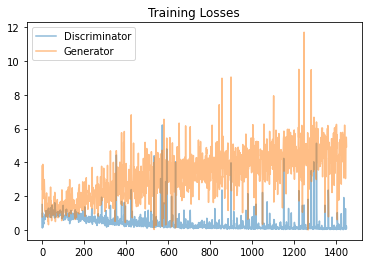

In [38]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

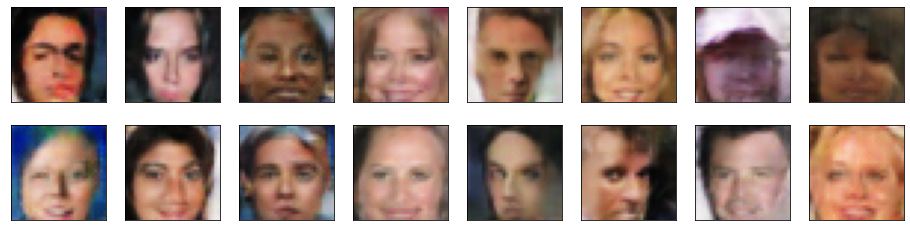

In [41]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

# V2 - Added smoothing to discriminator

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch Conv2d convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with Conv2d and optional BatchNorm2d layers
    """
    conv_layer = nn.Conv2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [44]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        # 32x32x3 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # No batch norm in first layer
        # 16x16x32
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4x128
        self.fc = nn.Linear(4 * 4 * conv_dim*4, 1)  # (2048, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4 * 4 * self.conv_dim*4)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [0]:
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch ConvTranspose2d transpose convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with ConvTranspose2d and optional BatchNorm2d layers
    """
    t_conv_layer = nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [t_conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [46]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.z_size = z_size

        self.fc1 = nn.Linear(z_size, 4 * 4 * conv_dim*4)  # (z_size, 2048)
        
        # 4x4x128
        self.t_conv1 = t_conv(conv_dim*4, conv_dim*2, 4)
        # 8x8x64
        self.t_conv2 = t_conv(conv_dim*2, conv_dim, 4)
        # 16x16x32
        self.t_conv3 = t_conv(conv_dim, 3, 4, batch_norm=False)
        # 32x32x3

        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = self.t_conv1(x)
        x = F.relu(x)
        x = self.t_conv2(x)
        x = F.relu(x)
        x = self.t_conv3(x)
        x = self.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Linear and Conv layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [49]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=200, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [0]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)  # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [0]:
import torch.optim as optim

# params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [0]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # 1. Train with real images, compute the discriminator losses on real images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # 2. Train with fake images, generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 3. Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # 4. Add up real and fake losses
            d_loss = d_real_loss + d_fake_loss
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            d_loss.backward()
            d_optimizer.step()
            
            # Train the generator with an adversarial loss with fake images and flipped labels
            g_optimizer.zero_grad()
            
            # 1. Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 2. Compute the discriminator losses on fake images, using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)  # use real loss to flip labels
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [54]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4004 | g_loss: 1.1027
Epoch [    1/   50] | d_loss: 0.4203 | g_loss: 3.5636
Epoch [    1/   50] | d_loss: 0.4096 | g_loss: 3.3968
Epoch [    1/   50] | d_loss: 0.4581 | g_loss: 3.7862
Epoch [    1/   50] | d_loss: 0.5386 | g_loss: 2.5404
Epoch [    1/   50] | d_loss: 0.5376 | g_loss: 3.1143
Epoch [    1/   50] | d_loss: 0.6039 | g_loss: 2.3838
Epoch [    1/   50] | d_loss: 0.7571 | g_loss: 3.0471
Epoch [    1/   50] | d_loss: 0.7022 | g_loss: 1.7388
Epoch [    1/   50] | d_loss: 0.7123 | g_loss: 2.2565
Epoch [    1/   50] | d_loss: 0.7219 | g_loss: 1.9592
Epoch [    1/   50] | d_loss: 0.8215 | g_loss: 1.4549
Epoch [    1/   50] | d_loss: 0.6770 | g_loss: 2.0923
Epoch [    1/   50] | d_loss: 0.9091 | g_loss: 1.5693
Epoch [    1/   50] | d_loss: 0.8795 | g_loss: 1.9324
Epoch [    1/   50] | d_loss: 1.0516 | g_loss: 1.5218
Epoch [    1/   50] | d_loss: 1.0323 | g_loss: 1.6384
Epoch [    1/   50] | d_loss: 1.1197 | g_loss: 2.3746
Epoch [    1/   50] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

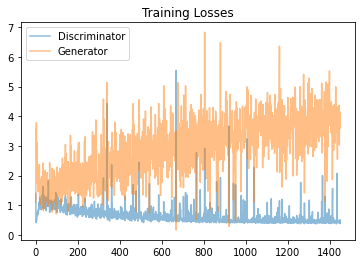

In [55]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

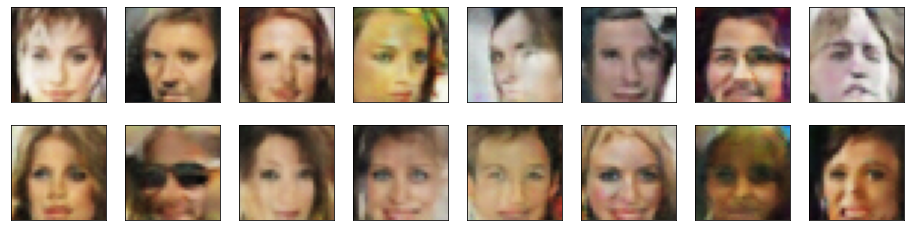

In [58]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

# V3 - Increased Layers in D and G, Increase conv_dim from 32 to 64 in G

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch Conv2d convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with Conv2d and optional BatchNorm2d layers
    """
    conv_layer = nn.Conv2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        # 32x32x3 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # No batch norm in first layer
        # 16x16x32
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4x128
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2x256
        self.fc = nn.Linear(2 * 2 * conv_dim*8, 1)  # (1024, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv4(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 2 * 2 * self.conv_dim*8)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [0]:
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a PyTorch ConvTranspose2d transpose convolutional layer, with optional batch normalisation
    Inputs:
        in_channels (int) - number of input channels to the convolutional layer
        out_channels (int) - number of output channels to the convolutional layer
        kernel_size (int) - size of kernel window
        stride (int) - number of pixels the window moves in each step
        padding (int) - number of pixels to extend the image with additional zero values
        batch_norm (bool) - whether a PyTorch BatchNorm2d layer is to be applied
    Returns: PyTorch Sequential container with ConvTranspose2d and optional BatchNorm2d layers
    """
    t_conv_layer = nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size, stride, padding, bias=False
    )
    
    layers = [t_conv_layer]
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.z_size = z_size

        self.fc1 = nn.Linear(z_size, 2 * 2 * conv_dim*8)  # (z_size, 1024)
        
        # 2x2x256
        self.t_conv1 = t_conv(conv_dim*8, conv_dim*4, 4)
        # 4x4x128
        self.t_conv2 = t_conv(conv_dim*4, conv_dim*2, 4)
        # 8x8x64
        self.t_conv3 = t_conv(conv_dim*2, conv_dim, 4)
        # 16x16x32
        self.t_conv4 = t_conv(conv_dim, 3, 4, batch_norm=False)
        # 32x32x3

        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = self.t_conv1(x)
        x = F.relu(x)
        x = self.t_conv2(x)
        x = F.relu(x)
        x = self.t_conv3(x)
        x = F.relu(x)
        x = self.t_conv4(x)
        x = self.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Linear and Conv layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [41]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [0]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)  # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [0]:
import torch.optim as optim

# params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [0]:
from datetime import datetime

def train(D, G, n_epochs, plot_every=10, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: (epochs) when to plot images
       param, print_every: (batch) when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    start_datetime = datetime.now()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # 1. Train with real images, compute the discriminator losses on real images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # 2. Train with fake images, generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 3. Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # 4. Add up real and fake losses
            d_loss = d_real_loss + d_fake_loss
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            d_loss.backward()
            d_optimizer.step()
            
            # Train the generator with an adversarial loss with fake images and flipped labels
            g_optimizer.zero_grad()
            
            # 1. Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # 2. Compute the discriminator losses on fake images, using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)  # use real loss to flip labels
            
            # 5. Perform backpropagation + an optimization step to update the discriminator's weights
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | Elapsed Time: {}'.format(
            epoch+1, n_epochs, d_loss.item(), g_loss.item(), str(datetime.now() - start_datetime)
        ))

        if epoch > 0 and epoch % plot_every == 0:

            fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples[epoch]):
                img = img.detach().cpu().numpy()
                img = np.transpose(img, (1, 2, 0))
                img = ((img + 1)*255 / (2)).astype(np.uint8)
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                im = ax.imshow(img.reshape((32,32,3)))
            plt.show()

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   50] | d_loss: 1.2438 | g_loss: 2.2485
Epoch [    1/   50] | d_loss: 1.4976 | g_loss: 0.7709
Epoch [    1/   50] | d_loss: 1.0198 | g_loss: 1.6319
Epoch [    1/   50] | d_loss: 1.1140 | g_loss: 1.2239
Epoch [    1/   50] | d_loss: 1.1512 | g_loss: 1.0377
Epoch [    1/   50] | d_loss: 1.0148 | g_loss: 1.3532
Epoch [    1/   50] | d_loss: 1.0614 | g_loss: 1.7874
Epoch [    1/   50] | d_loss: 1.1467 | g_loss: 1.6390
Epoch [    1/   50] | d_loss: 1.5045 | g_loss: 0.9481
Epoch [    1/   50] | d_loss: 1.0773 | g_loss: 1.3225
Epoch [    1/   50] | d_loss: 1.0659 | g_loss: 1.5548
Epoch [    1/   50] | d_loss: 1.0562 | g_loss: 1.3562
Epoch [    1/   50] | d_loss: 1.0035 | g_loss: 1.7569
Epoch [    1/   50] | d_loss: 1.0990 | g_loss: 1.2488
Epoch [    1/   50] | d_loss: 0.9933 | g_loss: 1.6643
Epoch [    1/   50] | d_loss: 0.9350 | g_loss: 1.6234
Epoch [    1/   50] | d_loss: 1.0334 | g_loss: 1.6554
Epoch [    1/   50] | d_loss: 1.3047 | g_loss: 0.9935
Epoch [    1/   50] | d_loss

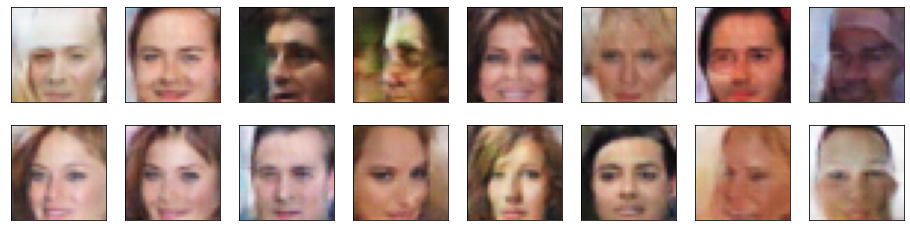

Epoch [   12/   50] | d_loss: 1.4585 | g_loss: 1.2465
Epoch [   12/   50] | d_loss: 0.7200 | g_loss: 1.9349
Epoch [   12/   50] | d_loss: 0.6453 | g_loss: 2.6483
Epoch [   12/   50] | d_loss: 0.8038 | g_loss: 1.9076
Epoch [   12/   50] | d_loss: 0.7742 | g_loss: 2.3040
Epoch [   12/   50] | d_loss: 0.7411 | g_loss: 2.0401
Epoch [   12/   50] | d_loss: 1.1321 | g_loss: 1.4828
Epoch [   12/   50] | d_loss: 1.1322 | g_loss: 1.4593
Epoch [   12/   50] | d_loss: 0.6035 | g_loss: 2.9164
Epoch [   12/   50] | d_loss: 0.8396 | g_loss: 1.9542
Epoch [   12/   50] | d_loss: 1.0311 | g_loss: 1.7879
Epoch [   12/   50] | d_loss: 0.8815 | g_loss: 1.9447
Epoch [   12/   50] | d_loss: 0.7043 | g_loss: 1.4864
Epoch [   12/   50] | d_loss: 0.9097 | g_loss: 2.1074
Epoch [   12/   50] | d_loss: 0.8403 | g_loss: 1.6787
Epoch [   12/   50] | d_loss: 0.9313 | g_loss: 1.8889
Epoch [   12/   50] | d_loss: 0.7476 | g_loss: 1.8826
Epoch [   12/   50] | d_loss: 0.9991 | g_loss: 0.9190
Epoch [   12/   50] | d_loss

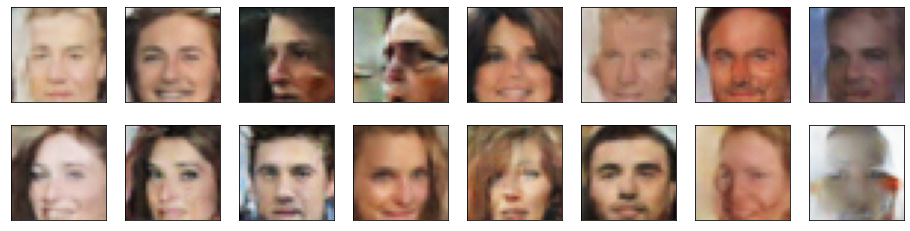

Epoch [   22/   50] | d_loss: 0.8630 | g_loss: 3.0595
Epoch [   22/   50] | d_loss: 0.6485 | g_loss: 2.7139
Epoch [   22/   50] | d_loss: 0.7287 | g_loss: 3.2810
Epoch [   22/   50] | d_loss: 0.6235 | g_loss: 3.0304
Epoch [   22/   50] | d_loss: 0.5698 | g_loss: 2.4693
Epoch [   22/   50] | d_loss: 0.6799 | g_loss: 2.9316
Epoch [   22/   50] | d_loss: 0.7477 | g_loss: 2.6493
Epoch [   22/   50] | d_loss: 0.7876 | g_loss: 2.3277
Epoch [   22/   50] | d_loss: 0.6671 | g_loss: 2.6613
Epoch [   22/   50] | d_loss: 0.8794 | g_loss: 3.5926
Epoch [   22/   50] | d_loss: 0.4885 | g_loss: 3.8143
Epoch [   22/   50] | d_loss: 0.5646 | g_loss: 2.9154
Epoch [   22/   50] | d_loss: 0.7157 | g_loss: 2.2878
Epoch [   22/   50] | d_loss: 1.0476 | g_loss: 3.7787
Epoch [   22/   50] | d_loss: 0.6030 | g_loss: 1.8612
Epoch [   22/   50] | d_loss: 0.5237 | g_loss: 2.5114
Epoch [   22/   50] | d_loss: 0.7126 | g_loss: 2.1733
Epoch [   22/   50] | d_loss: 0.7896 | g_loss: 1.5338
Epoch [   22/   50] | d_loss

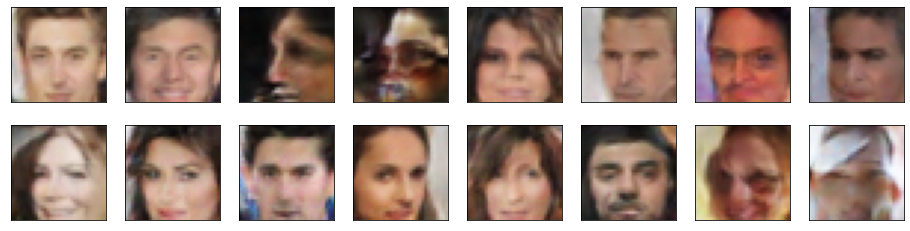

Epoch [   32/   50] | d_loss: 0.4895 | g_loss: 3.9996
Epoch [   32/   50] | d_loss: 0.5686 | g_loss: 2.7834
Epoch [   32/   50] | d_loss: 0.5654 | g_loss: 2.9527
Epoch [   32/   50] | d_loss: 0.5336 | g_loss: 3.3016
Epoch [   32/   50] | d_loss: 0.4094 | g_loss: 4.9095
Epoch [   32/   50] | d_loss: 0.5916 | g_loss: 2.6958
Epoch [   32/   50] | d_loss: 0.5627 | g_loss: 2.9422
Epoch [   32/   50] | d_loss: 0.5124 | g_loss: 2.6804
Epoch [   32/   50] | d_loss: 0.5192 | g_loss: 4.1446
Epoch [   32/   50] | d_loss: 0.5932 | g_loss: 4.5941
Epoch [   32/   50] | d_loss: 0.4246 | g_loss: 2.5910
Epoch [   32/   50] | d_loss: 0.6133 | g_loss: 3.0358
Epoch [   32/   50] | d_loss: 0.5472 | g_loss: 2.6256
Epoch [   32/   50] | d_loss: 0.4812 | g_loss: 3.4264
Epoch [   32/   50] | d_loss: 0.4729 | g_loss: 3.1589
Epoch [   32/   50] | d_loss: 0.4945 | g_loss: 3.5477
Epoch [   32/   50] | d_loss: 0.5097 | g_loss: 2.9794
Epoch [   32/   50] | d_loss: 0.5384 | g_loss: 2.0983
Epoch [   32/   50] | d_loss

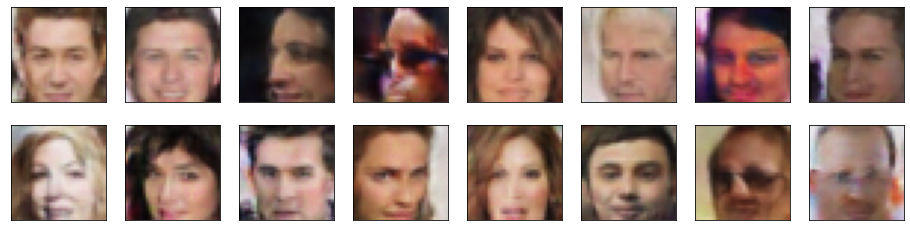

Epoch [   42/   50] | d_loss: 0.4447 | g_loss: 3.1577
Epoch [   42/   50] | d_loss: 0.6206 | g_loss: 2.3921
Epoch [   42/   50] | d_loss: 0.4348 | g_loss: 4.4310
Epoch [   42/   50] | d_loss: 0.4680 | g_loss: 3.3215
Epoch [   42/   50] | d_loss: 0.4579 | g_loss: 3.1825
Epoch [   42/   50] | d_loss: 0.3985 | g_loss: 4.3515
Epoch [   42/   50] | d_loss: 0.4077 | g_loss: 3.6293
Epoch [   42/   50] | d_loss: 0.5321 | g_loss: 4.1857
Epoch [   42/   50] | d_loss: 1.0639 | g_loss: 2.2639
Epoch [   42/   50] | d_loss: 0.5594 | g_loss: 3.7995
Epoch [   42/   50] | d_loss: 0.4195 | g_loss: 4.2672
Epoch [   42/   50] | d_loss: 0.5311 | g_loss: 2.8814
Epoch [   42/   50] | d_loss: 0.4467 | g_loss: 2.6836
Epoch [   42/   50] | d_loss: 0.5239 | g_loss: 2.2698
Epoch [   42/   50] | d_loss: 0.5127 | g_loss: 3.6109
Epoch [   42/   50] | d_loss: 0.5978 | g_loss: 2.7377
Epoch [   42/   50] | d_loss: 0.5174 | g_loss: 3.7226
Epoch [   42/   50] | d_loss: 0.7242 | g_loss: 2.5975
Epoch [   42/   50] | d_loss

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [49]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, plot_every=10, print_every=50)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

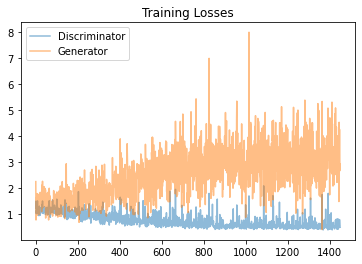

In [50]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

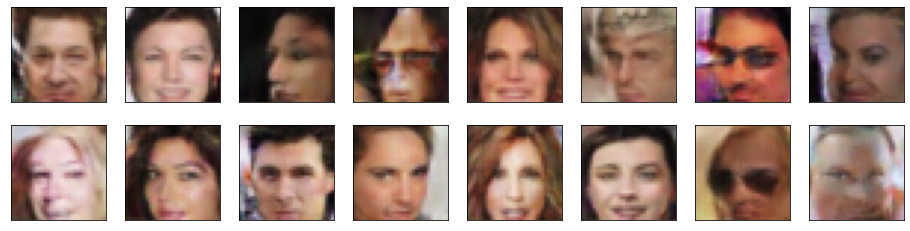

In [53]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.